<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/banner_IA.png"  width="1000px" height="200px">

# **Parcial 02 - IA**

## **Outline**

1. [Ejercicio 1. Clasificación](#eje1)
2. [Ejercicio 2. LeaveOneOut](#eje2)
3. [Ejercicio 3. Regresión](#eje3)
4. [Ejercicio 4. DNN](#eje4)

In [16]:
#@title 1. MONTAR EL DRIVE **student** { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/quiz02/')
print(os.getcwd())
!gdown -q 1Y7-HL0CFU3YHUy_ABwLdmvoUV2bUQO1V
!unzip -qq fsdd.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/quiz02
replace fsdd/9_yweweler_5.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace fsdd/9_yweweler_36.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fsdd/9_yweweler_30.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fsdd/9_yweweler_33.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [17]:
#@title **Execute this cell**
#@markdown Please include your student id
import sys
import inspect

group_id = "IA1-20221-H2" #@param {type:"string"}
assignment_id = group_id +'.parcial-2-20221'
student_id = "2182689" #@param {type:"string"}
"""
Put your student ID here

Example: student_id =  '2152145'
""" 

"\nPut your student ID here\n\nExample: student_id =  '2152145'\n"

In [18]:
 #@title **Execute this cell**
#@markdown **UTILS**
#@markdown Please dont modify any line in this cell

import os
import json
import requests
from collections import namedtuple


Config = namedtuple('Config', ['server_name'])
config = Config(server_name='https://bivlabgrader.azurewebsites.net/api')


def check_solution_and_evaluate(assignment_id: str, student_func_str: str):

    # Set the endpoint and payload.
    payload = {
        'func_str': student_func_str,
        'assignment_id': assignment_id,
        'student_id': student_id
    }
    endpoint_url = config.server_name + '/CheckAndEvaluateSolution'
    # print(endpoint_url)

    # Make request to server with the data coming from the notebook.
    r = requests.post(endpoint_url, params=payload)
    pprint_json_response(r.json())
    return r


def pprint_json_response(response, indent=0):
    """Pretty print the response."""
    for key, value in response.items():
        print('\t' * indent + str(key.capitalize()))

        # If dictionary, do a recurrent call.
        if isinstance(value, dict):
            pprint_json_response(value, indent + 1)
        else:
            # Enumerate elements if list.
            if isinstance(value, list):
                if len(value) == 1:
                    print('\t' * (indent + 1) + str(value[0]))
                else:
                    for i, e in enumerate(value, start=1):
                        print('\t' * (indent + 1) + f'{i}. {e}')
            else:
                print('\t' * (indent + 1) + str(value))

def send_results_fun_20221_p02_04(model):
  import json
  import sys
  import numpy as np
  import tensorflow as tf

  submission_str = 'def fun_20221_p02_04():\n    import numpy as np\n    xmd\n    xpd\n    return model_dict, test_predictions\n'

  !gdown -q 1-1bamlnoRGMJw419oKqzlUup6QTh2B8J
  x_test = np.load("x2.npy")
  test_predictions = model.predict(x_test)
  test_predictions = np.argmax(test_predictions, axis=-1)

  # Make sure the type and shape of the array is correct.
  test_predictions = test_predictions.astype(np.int64)
  if test_predictions.ndim > 1:
      test_predictions = test_predictions.flatten()
      print(f'Flattened your predictions to shape: {test_predictions.shape}')

  # Create the string to replace on submission_str.
  with np.printoptions(threshold=sys.maxsize):
      preds_str = ('test_predictions = np.' + np.array_repr(test_predictions)
                  .replace('int64', 'np.int64'))
  
  # Replace placeholders.
  model_dict = {i+1: model.layers[i+1].get_config()['units'] for i in range(4)}
  model_str = "model_dict = " + json.dumps(model_dict)
  submission_str = submission_str.replace('xpd', preds_str)
  submission_str = submission_str.replace('xmd', model_str)

  check_solution_and_evaluate(assignment_id, submission_str)

---
#### Usted debe ejecutar **TODAS** las celdas de tipo **CODE**. De lo contrario, sus respuestas no serán procesadas correctamente.
---

In [51]:
#@title **Import libraries**
import numpy as np
import tensorflow as tf
from tensorflow import keras

## **Stroke dataset**

Vamos a explorar un dataset que contiene los datos de 5109 pacientes que fueron evaluados en centros clínicos y fueron diagnosticados con o sin accidente cerebrovascular (Stroke). Este dataset cuenta con 12 columnas asociadas a información clínica y socioeconómica de los pacientes.

[Fuente](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
32,39373,2,82.00,1,0,1,4,0,196.92,22.2,1,1
3466,10374,2,24.00,0,0,1,3,1,76.42,24.8,2,0
1812,12366,2,35.00,0,0,0,3,0,97.58,24.3,3,0
4302,24972,1,1.48,0,0,0,0,1,112.02,20.9,3,0
2477,24096,2,34.00,1,0,1,4,0,100.61,0.0,3,0


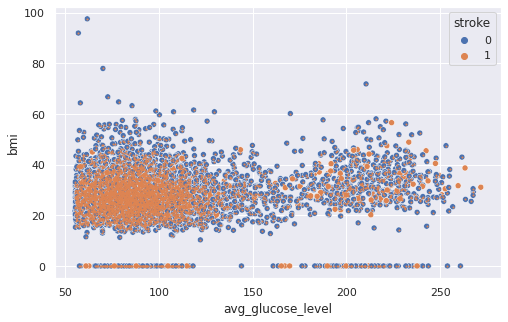

In [23]:
#@title **Stroke dataset**
cols = ["id", "gender", "age", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "smoking_status", "stroke"]
variable_x = "avg_glucose_level" #@param {type:"string"}
variable_y = "bmi" #@param {type:"string"}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
sns.set_theme()

X = pd.read_csv("https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/-/raw/master/data/stroke.csv", header=0)
X = shuffle(X)
plt.figure(figsize=(8,5))
sns.scatterplot(data=X, x=X[variable_x], y=X[variable_y], hue="stroke")
plt.scatter(X[variable_x], X[variable_y], s=1)

X.head()

# **Ejercicio 1. Clasificación**  <a name="eje1"></a>

Implemente la clasificación de pacientes sobre el dataset Stroke.<br>
Recuerde que `stroke=0` corresponde a pacientes control y `stroke=1` corresponde a pacientes que padecen accidente cerebrovascular (Stroke).

Resuelva las siguientes tareas:
1. Obtenga las "mejores características" usando un estimador **`DecisionTreeClassifier`** con parámetros `random_state=21`
2. Con las **mejores características**, entrenamos un nuevo estimador **`RandomForestClassifier`** con parámetros `n_estimators=50` y `random_state=21`
3. **Devuelva** el puntaje obtenido con la métrica **recall**
4. **Devuelva** el puntaje obtenido con la métrica **accuracy**<br><br>

5. Ahora, usando **todas** las características, use un estimador **`RandomForestClassifier`** con parámetros `n_estimators=100`, `criterion='entropy'`, `random_state=21`
6. **Devuelva** el puntaje obtenido con la métrica **f1**

Para esto, se debe crear una función que reciba `x_train`,`x_test`,`y_train`, `y_test` y el número de mejores características `n` que se van a utilizar.<br><br>

<b>Referencia recall_score:</b> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html<br>
<b>Referencia f1_score:</b> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html<br>
<b>Referencia accuracy_score:</b> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html<br><br>

<b>Referencia DecisionTreeClassifier:</b> https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html<br>
<b>Referencia RandomForestClassifier:</b> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br>


In [72]:
#@title **code student**
def fun_20221_p02_01(X_train, X_test, y_train, y_test, n):
  import numpy as np
  import pandas as pd
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.metrics import recall_score
  from sklearn.metrics import f1_score
  from sklearn.metrics import accuracy_score
  
  np.random.seed(21)

  est1 = DecisionTreeClassifier(random_state=21)
  est1.fit(X_train, y_train)
  features = est1.feature_importances_
  bestfeat = np.argsort(features)[::-1][:n]
  bestcols = []
  for c in range(n):
      bestcols.append(X_train.columns[bestfeat[c]])

  X_train_best = X_train[bestcols]
  X_test_best = X_test[bestcols]

  est2 = RandomForestClassifier(n_estimators=50, random_state=21)
  est2.fit(X_train_best, y_train)
  pred = est2.predict(X_train)
  s1 = recall_score(X_test_best, y_test)
  s2 = accuracy_score(X_test_best, y_test)

  est3 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=21)
  est3.fit(X_train, y_test)
  pred = est3.predict(X_train)
  s3 = f1_score(X_test_best, y_test)
  return s1, s2, s3

In [73]:
from sklearn.model_selection import train_test_split

cols = [c for c in X.columns[:-1]]
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,cols], X["stroke"], test_size=0.2, random_state=21)
n = 4
print(fun_20221_p02_01(X_train, X_test, y_train, y_test, n))

#@title **send your answer**
student_func_str = inspect.getsource(fun_20221_p02_01)
r = check_solution_and_evaluate(assignment_id, student_func_str)

ValueError: ignored

<br><br><br>

# **Ejercicio 2. LeaveOneOut**  <a name="eje2"></a>

Para este ejercicio vamos a utilizar una versión reducida del dataset Stroke, la cual cuenta con 200 ejemplos, por lo que una partición grande para el test puede incurrir en un aprendizaje debil (pocos datos de entrenamiento). Vamos a implementar una función que realice un esquema de validación **leave-one-out**, por lo tanto desarrolle una función que: 

- **Devuelva** el número de splits `ns` obtenido usando el método `LeaveOneOut`

- Como clasificadores utilice:
 - `RandomForestClassifier` con parámetros `n_estimators=20` y `random_state=21`
 - `SVC` con el parámetro `kernel='poly'` y `random_state=21`
 - `SVC` con el parámetro `kernel='rbf'` y `random_state=21`

- **Devuelva** el **promedio** de la métrica `f1_score` para estos clasificadores, una variable por cada uno.

- **Devuelva** la **desviación estándar** de la métrica `f1_score` para estos clasificadores, una variable por cada uno.<br><br>


<b>Referencia Leave One Out:</b> https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html

In [71]:
#@title **code student**
def fun_20221_p02_02(data, y):
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import LeaveOneOut
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import f1_score
    np.random.seed(21)
    print(data.shape)

    loo = LeaveOneOut()
    ns = loo.get_n_splits(data)
    est1 = RandomForestClassifier(n_estimators=20,random_state=21)
    est2 = SVC(kernel='poly',random_state=21)
    est3 = SVC(kernel='rbf',random_state=21)

    score1 = []
    score2 = []
    score3 = []

    for train_index, test_index in loo.split(data):
        est1.fit(data[train_index], y[train_index])
        est2.fit(data[train_index], y[train_index])
        est3.fit(data[train_index], y[train_index])
        pred1 = est1.predict(X_train)
        pred2 = est2.predict(X_train)
        pred3 = est3.predict(X_train)

        score1.append(data([test_index],y[test_index], pred1))
        score2.append(data([test_index],y[test_index], pred2))
        score3.append(data([test_index],y[test_index], pred3))
 
    return ns, np.mean(score1), np.mean(score2), np.mean(score3), np.std(score1), np.std(score2), np.std(score3)

In [33]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

X2 = pd.read_csv("https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/-/raw/master/data/stroke2.csv", header=0)
X2 = shuffle(X2)

cols = [c for c in X2.columns[:-1]]

ns, score1, score2, score3, std1, std2, std3 = fun_20221_p02_02(X2.loc[:,cols].to_numpy(), X2["stroke"])
print(ns, score1, score2, score3, std1, std2, std3)
f = plt.figure(figsize=(12,3))
f.subplots_adjust(wspace=0.5)

ax1 = f.add_subplot(121)
ax1.bar([0,1,2], [score1,score2,score3])
ax1.set_xticks(range(0,3))
ax1.set_xticklabels(('RF', 'SVC-poly', 'SVC-rbf'))
ax1.set_ylabel('f1_score')
ax1.text(-0.1, 0.35, str(score1)[:8])
ax1.text(0.82, 0.35, str(score2)[:8])
ax1.text(1.86, 0.35, str(score3)[:8])
plt.show()

#@title **send your answer**
student_func_str = inspect.getsource(fun_20221_p02_02)
r = check_solution_and_evaluate(assignment_id, student_func_str) 

(200, 11)


TypeError: ignored

<br><br><br>

# **Ejercicio 3. Regresión**  <a name="eje3"></a>

Vamos a hacer una función que explore los regresores **`DecisionTreeRegressor`, `RandomForestClassifier`** y **`SVR`** para el dataset Stroke, realizando lo siguiente: 

- Utilizar **solamente** las características: `avg_glucose_level`, `hypertension`, `smoking_status`

- La característica `bmi` (Body mass index) será el objetivo de la primera regresión

- El 70% del dataset se utilizará como train `X_train`, `y_train`

- El 30% del dataset restante se utilizará como test: `X_test`, `y_test`

- Realice una exploración para los regresores: **`DecisionTreeRegressor(random_state=21)`, `RandomForestRegressor(random_state=21)`** y **`SVR(kernel='rbf')`**

- Devuelva **una lista** `scores` con el valor del **mean squared error (MSE)** para cada uno de los tres regresores.

- Devuelva **una lista** `predictions` con las predicciones para cada uno de los tres regresores.<br><br>


<b>Referencia Decision Tree Regressor:</b> https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html<br>
<b>Referencia Random Forest Regressor:</b> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html<br>
<b>Referencia Support Vector Regression:</b> https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html<br>
<b>Referencia mean_squared_error:</b> 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html<br><br>

In [74]:
#@title **code student**
def fun_20221_p02_03(data):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
    from sklearn.metrics import mean_squared_error
    import numpy as np
    import pandas as pd
    np.random.seed(21)

    X = data[['avg_glucose_level', 'hypertension', 'smoking_status']]
    y = data['bmi']
    
    X_train = X[:int((len(X))*0.7)]
    y_train = y[:int((len(X))*0.7)]
    X_test = X[int((len(X))*0.7):]
    y_test = y[int((len(X))*0.7):]

    regressors = []
    regressors.append(DecisionTreeRegressor(random_state=21))
    regressors.append(RandomForestRegressor(random_state=21))
    regressors.append(SVR(kernel='rbf'))

    scores = []
    predictions = []

    for i in regressors:
        i.fit(X_train, y_train)
        p = i.predict(X_test)
        scores.append(mean_squared_error(y_test,p))
        predictions.append(p)

    return scores, predictions

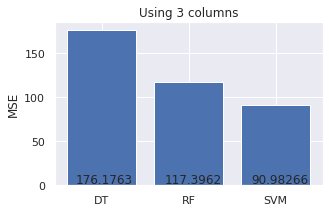

In [75]:
#@title **check your answer**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
np.random.seed(21)

X = pd.read_csv("https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/-/raw/master/data/stroke.csv", header=0)
X = shuffle(X)
scores, predictions = fun_20221_p02_03(X)

f = plt.figure(figsize=(12,3))
f.subplots_adjust(wspace=0.5)

ax1 = f.add_subplot(121)
ax1.set_title('Using 3 columns')
ax1.bar(range(0,len(scores)), scores)
ax1.set_xticks(range(0,len(scores)))
ax1.set_xticklabels(('DT', 'RF', 'SVM'))
ax1.set_ylabel('MSE')
ax1.text(-0.3, 2.5, str(scores[0])[:8])
ax1.text(0.72, 2.5, str(scores[1])[:8])
ax1.text(1.72, 2.5, str(scores[2])[:8])
plt.show()

In [76]:
#@title **send your answer**
student_func_str = inspect.getsource(fun_20221_p02_03)
r = check_solution_and_evaluate(assignment_id, student_func_str) 

Score
	5
Message
	Well done. You got the highest score.
Status
	You have achieved your best score: 5


<br><br><br>

# **Ejercicio 4. DNN**  <a name="eje4"></a>


El dataset **Free Spoken Digit Dataset (FSDD)** contiene grabaciones de audio de 4 personas diferentes ("jackson", "nicolas", "theo", "yweweler"), pronunciando 50 veces cada uno de los números dígitos (números del 0 al 9).<br>

a) En el siguiente ejercicio usted deberá utilizar las grabaciones correspondientes a los números dígitos 1, 2, 3, 4, 5 y 6 para entrenar. Y deberá usar las grabaciones de los dígitos 7 y 8 para validación. Para ello, modifique la función `getFiles` de manera que guarde los nombres de archivo para entrenamiento o para validación en una lista.<br>La función debe **devolver** esa lista.<br>

b) También deberá modificar la función `subjectToNumber` para que codifique los nombres de las personas de la siguiente forma: 
  - "jackson": 0<br>
  - "nicolas": 1<br>
  - "theo": 2<br>
  - "yweweler": 3<br>

Esta función debe **devolver** el número que codifica al nombre que se le ingrese.

<br>**Nota:** NO modifique la función `get_XyData`<br><br>

c) Posteriormente, escriba un bloque secuencial de código (**es decir, NO escriba una función**) que: 

- Utilice las particiones de entrenamiento y test proporcionadas (`X_train`, `X_test`, `y_train`, `y_test`). 

- Haga una red DNN, que reciba como entrada las muestras del dataset y tenga como salida el número relacionado con las clases del dataset (los sujetos o personas que pronuncian cada dígito).

- Asigne el número de clases a la variable `nc` de forma dinámica (**obténgalo**, no le asigne un número manualmente)

- Recuerde utilizar one-hot-encoding

- Se deben crear:
 - Para la capa de entrada, utilice las dimensiones del primer dato de entrenamiento para el parámetro `input_shape`
 - Una capa oculta, Densa, con 128 neuronas y función de activación `relu`
 - Una capa oculta, Densa, con 64 neuronas y función de activación `relu`
 - Una capa oculta, Densa, con 32 neuronas y función de activación `relu`

- Compile el modelo con: `optimizer=tf.keras.optimizers.SGD()`, `loss='categorical_crossentropy'` y `metrics=['accuracy']`

- Entrene el modelo con la configuración: `epochs=40`

- Cree una **variable** `model` que contenga el modelo `DNN`

- Cree una **variable** `preds` con las predicciones para la partición de testing. Recuerde que la función de activación softmax devuelve varios números y se esta pidiendo **una** predicción (es decir, **un** solo número).
<br><br>



In [ ]:
#@title **Code student**
import os
import librosa
import numpy as np

def func_padding(wav, pad_size=2000):
    if wav.shape[0] > pad_size:
        return wav[0: pad_size]
    else:
        return np.hstack((wav, np.zeros(pad_size - wav.shape[0])))

def getFiles(DATA_DIR, stage):
    files = None
    for i in os.listdir(DATA_DIR):
        num = None
        if stage=="train":
            if None:
                files.None
        else:
            if None:
                files.None
    return files

def subjectToNumber(subject):
    if None:
        None
    if None:
        None
    if None:
        None
    if None:
        None
    return num

def get_XyData(DATA_DIR):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    print("obtaining train files...")
    files_train = getFiles(DATA_DIR, "train")
    print("obtaining test files...")
    files_test = getFiles(DATA_DIR, "test")
    print("loading train files...")
    for fname in files_train:
        y_train.append(subjectToNumber(fname.split('_')[1]))
        wav, _ = librosa.load(DATA_DIR + fname)
        D = librosa.feature.melspectrogram(wav)
        padded = func_padding(D.reshape(D.shape[0]*D.shape[1]))
        X_train.append(padded)
    print("loading test files...")
    for fname in files_test:
        y_test.append(subjectToNumber(fname.split('_')[1]))
        wav, _ = librosa.load(DATA_DIR + fname)
        D = librosa.feature.melspectrogram(wav)
        padded = func_padding(D.reshape(D.shape[0]*D.shape[1]))
        X_test.append(padded)

    return np.vstack(X_train), np.array(y_train), np.vstack(X_test), np.array(y_test)

DATA_DIR = '/content/drive/My Drive/quiz02/fsdd/'
X_train, y_train, X_test, y_test = get_XyData(DATA_DIR)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print('Done. Please continue.')

In [ ]:
#@title **Code student** <br>Recuerde: **NO** escriba una función.<br>Recuerde: las variables a calcular **deben llamarse** `model` y `preds`
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(21)
np.random.seed(21)

nc = None

y_train_ohe = tf.keras.utils.None(None, num_classes=None)
y_test_ohe = tf.keras.utils.None(None, num_classes=None)

model = None([
    None,
    None,
    None,
    None,
    None
])

model.None(None, None, None)
model.None(None, None, None)

test_loss, test_acc = model.None(None, None)

probs = model.None(None)
preds = np.None(probs, axis=1)

In [ ]:
#@title **check and send your answer**
send_results_fun_20221_p02_04(model)

<br><br><br>

---
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/bannerThanks.jpg" alt="Drawing" style="width:700px;"/>